In [41]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

from matplotlib import pyplot as plt

import util
reload(util);

import luna_util
reload(luna_util);

import luna_preprocess
reload(luna_preprocess);

In [42]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

In [43]:
p1_file = file_list[200]

In [44]:
image, lung_mask, nodule_mask = luna_preprocess.process_file(p1_file, annt_df, 1, False)

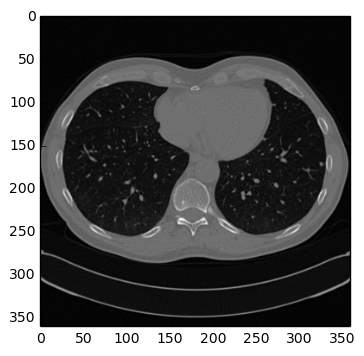

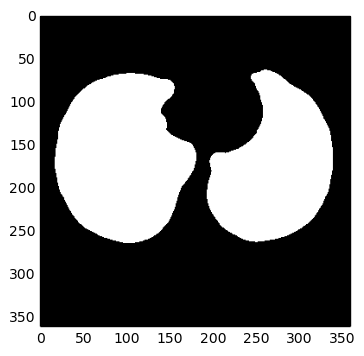

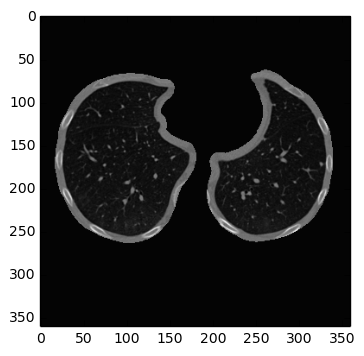

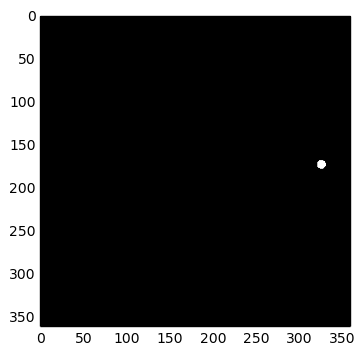

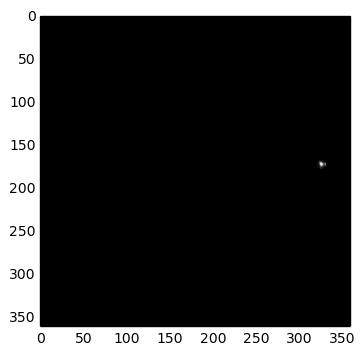

In [45]:
z = 1

plt.figure()
plt.imshow(image[z], cmap="gray")
plt.show()

plt.figure()
plt.imshow(lung_mask[z], cmap="gray")
plt.show()

plt.figure()
plt.imshow(util.apply_mask(image[z], lung_mask[z]), cmap="gray")
plt.show()

plt.figure()
plt.imshow(nodule_mask[z], cmap="gray")
plt.show()

plt.figure()
plt.imshow(util.apply_mask(image[z], nodule_mask[z]), cmap="gray")
plt.show()